In [4]:
from collections import defaultdict

import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2
import networkx as nx
from PIL import Image

In [5]:
img_path = r"C:\Users\pshun\Documents\python\tkinter_killingtime\niwatori.jpg"
orig_img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

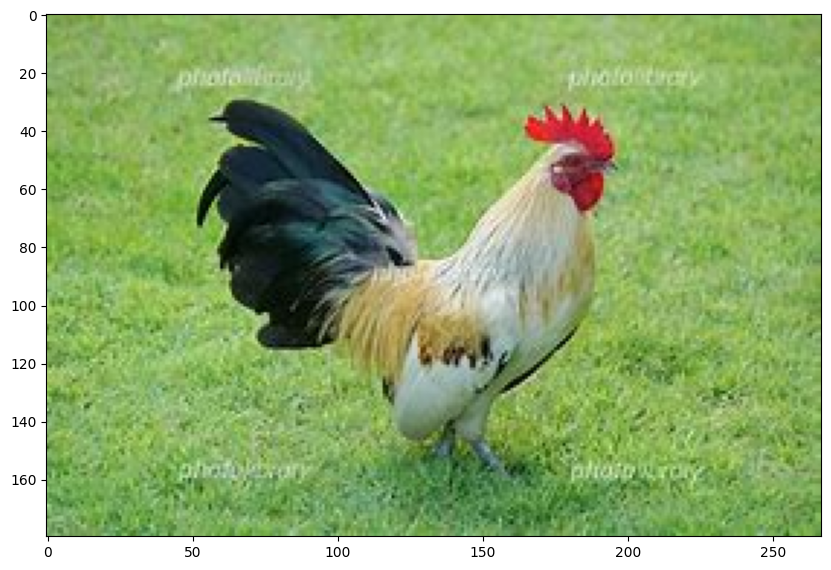

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(Image.fromarray(orig_img))

(180, 267)


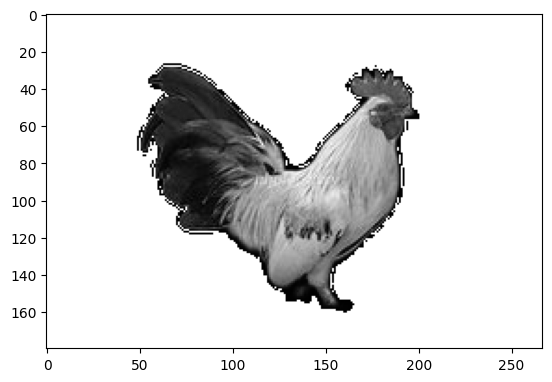

In [18]:
# remove background
import cv2
from rembg import remove
from PIL import Image
import numpy as np

def remove_background(input_image):
    # 背景を削除

    input_image = Image.fromarray(input_image)

    output_image = np.array(remove(input_image))
    mask = (output_image[:, :, 3] == 0)
    print(mask.shape)
    for i in range(3):
        output_image[:, :, i][mask] = 255
    return output_image

img_pil = remove_background(orig_img)
img_np = np.array(img_pil)
gray_img = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_img, cmap="gray")

In [5]:
gray_img = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)

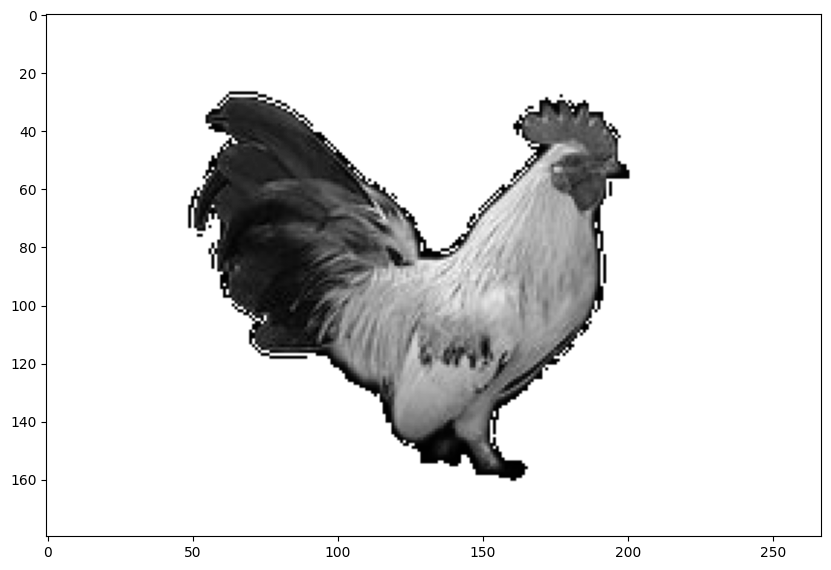

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(Image.fromarray(gray_img))
plt.gray()

In [20]:
layer_img = 255.0 - gray_img
layer_img = cv2.GaussianBlur(layer_img, (0, 0), 1)

In [21]:
# 覆い焼きカラー
curve_img = np.clip(gray_img.astype(np.float32) * 255 / (255 - layer_img), 0, 255).astype(np.uint8)

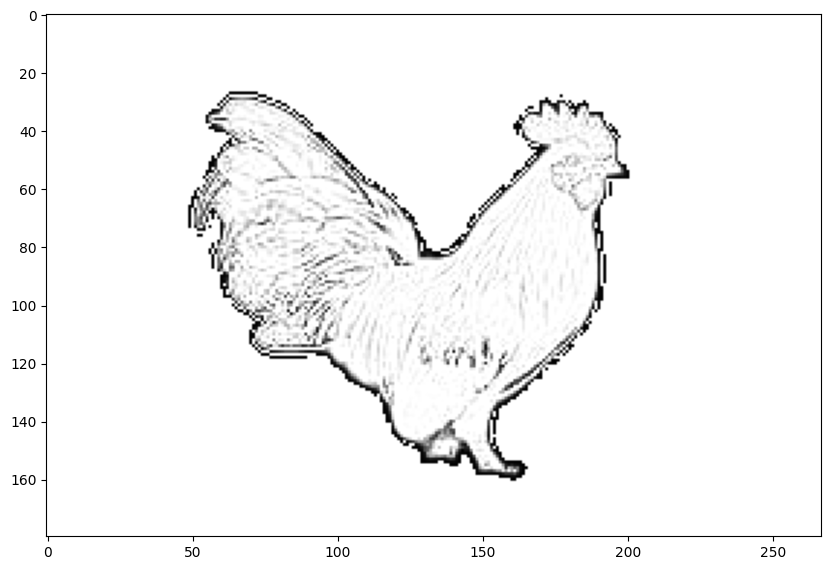

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(Image.fromarray(curve_img))
plt.gray()

In [23]:
threshold = 240
curve_img[curve_img >= threshold] = 255
curve_img[curve_img < threshold] = 0

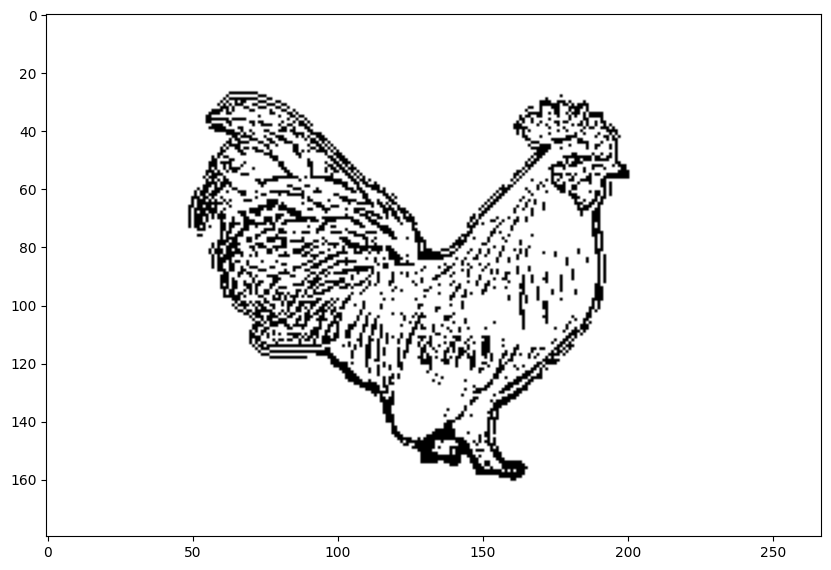

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(Image.fromarray(curve_img))
plt.gray()

In [11]:
Image.fromarray(curve_img).save("./haato_curve.png")

In [12]:
# 手で修正
curve_img = cv2.imread("./haato_curve_fixed.png", cv2.IMREAD_UNCHANGED)
curve_img = cv2.cvtColor(curve_img, cv2.COLOR_BGR2GRAY)

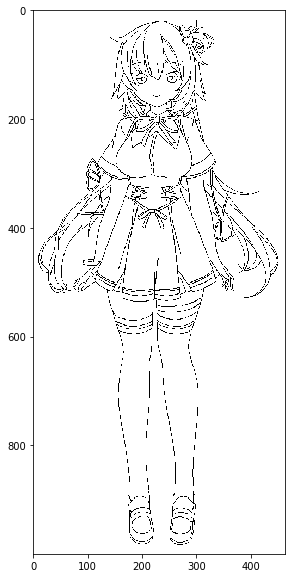

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(Image.fromarray(curve_img))
plt.gray()

In [25]:
x, y = np.where(curve_img == 0)

neighborhood_size = 4

points_list = list(zip(x, y))
lines = []
while len(points_list) > 0:
    idx = np.random.choice(len(points_list))
    line = [points_list[idx]]
    del points_list[idx]
    
    reversed_flag = False
    while len(points_list) > 0:
        points = np.array(points_list)
        distances = np.linalg.norm(points - line[-1], axis=-1)
        nearest_points_length = (distances <= neighborhood_size).sum()
        if nearest_points_length == 0:
            if not reversed_flag:
                reversed_flag = True
                line = line[::-1]
                continue
            else:
                break
        
        nearest_indices = np.argsort(distances)[:nearest_points_length]
        nearest_points = points[nearest_indices]
        
        if len(line) <= 3:
            line.append(points_list[nearest_indices[0]])
            del points_list[nearest_indices[0]]
        else:
            line_array = np.array(line)
            d = (line_array[-1] - line_array[-2]) + (line_array[-2] - line_array[-3]) / 2
            norm = np.linalg.norm(d)
            if norm > 0.0:
                d = d / norm
            n = np.copy(d)[::-1]
            n[0] = -n[0]
            
            s = [(ss - line_array[-1]) for ss in nearest_points]
            s = [np.sqrt((d @ ss)**2 + 2 * (n @ ss)**2) for ss in s]
            
            idx = np.argsort(s)[0]
            line.append(points_list[nearest_indices[idx]])
            del points_list[nearest_indices[idx]]

    lines.append(line)

In [26]:
lines = [line for line in lines if len(line) >= neighborhood_size]

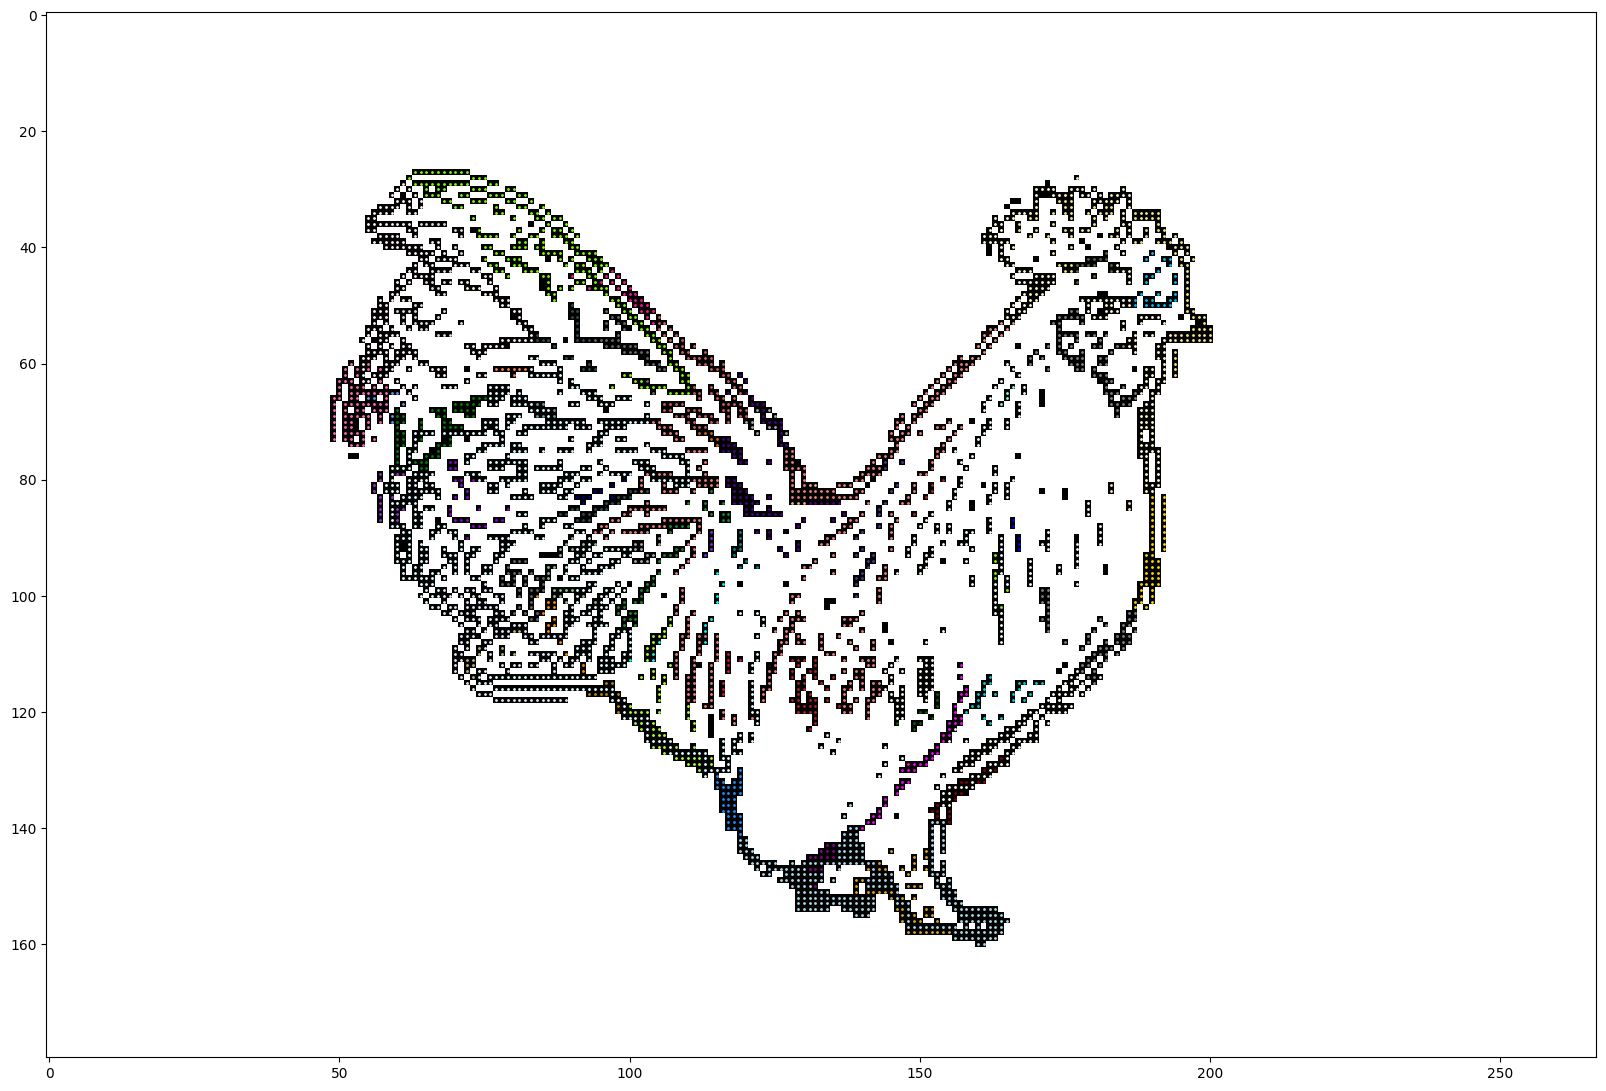

In [27]:
plt.figure(figsize=(20, 20))
plt.imshow(Image.fromarray(curve_img))

colors = list(matplotlib.colors.cnames.keys())

cnt = 0
for line in sorted(lines, key=lambda x: len(x)):
    x = [p[1] for p in line]
    y = [p[0] for p in line]
    plt.scatter(x, y, s=1, c=colors[cnt])
    
    cnt += 1
    if cnt >= len(colors):
        cnt = 0

In [28]:
split_points_data = []
for line in tqdm.tqdm(lines):
    split_points = []
    for point in line:
        for line2 in lines:
            if line == line2:
                continue
            
            if len(split_points) > 0:
                distances = np.linalg.norm(np.array(split_points) - np.array(point), axis=-1)
                nearest_points_length = (distances <= neighborhood_size).sum()
                if nearest_points_length > 0:
                    continue
            
            distances = np.linalg.norm(np.array(line2) - np.array(point), axis=-1)
            nearest_points_length = (distances <= 1.5).sum()
            if nearest_points_length > 0:
                split_points.append(point)
                break
                
    split_points_data.append(split_points)

100%|██████████| 70/70 [00:07<00:00,  9.85it/s]


In [29]:
splitted_lines = []
for line, split_points in zip(lines, split_points_data):
    indices = [0] + [e for e, p in enumerate(line) if p in split_points]
    splitted_lines.extend([line[i:j] for i,j in zip(indices, indices[1:]+[None])])

lines = splitted_lines
lines = [line for line in lines if len(line) >= 1]

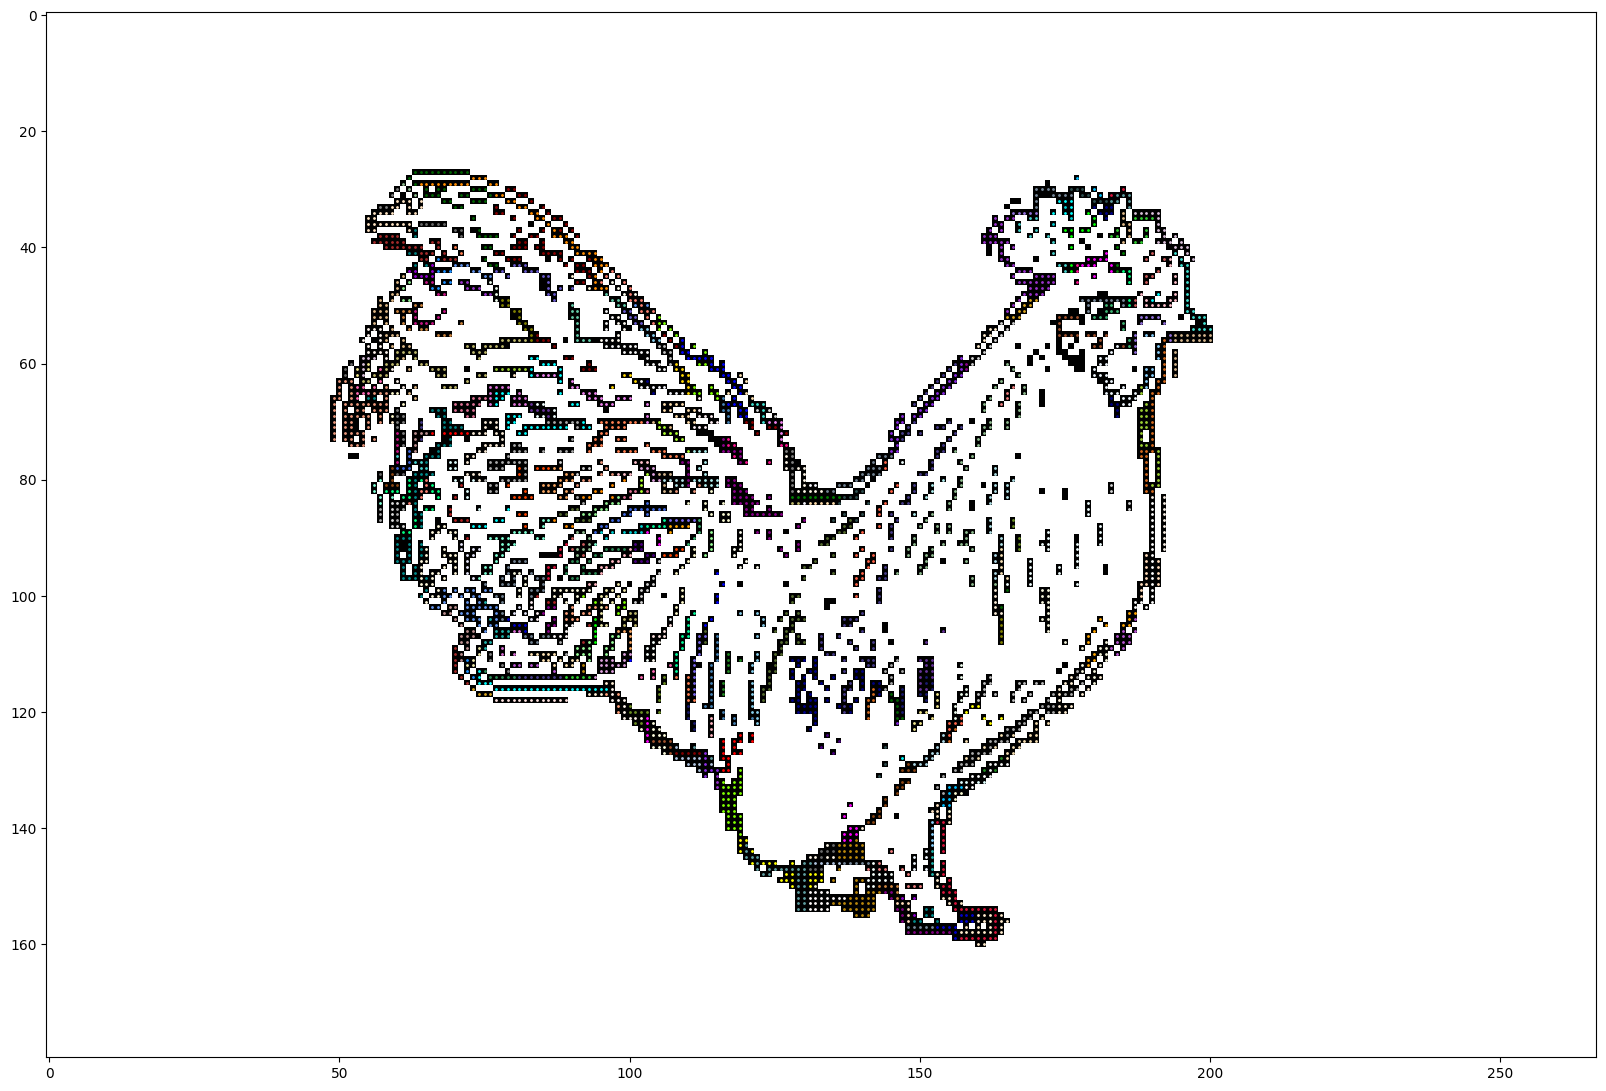

In [30]:
plt.figure(figsize=(20, 20))
plt.imshow(Image.fromarray(curve_img))

colors = list(matplotlib.colors.cnames.keys())

cnt = 0
for line in sorted(lines, key=lambda x: len(x)):
    x = [p[1] for p in line]
    y = [p[0] for p in line]
    plt.scatter(x, y, s=1, c=colors[cnt])
    
    cnt += 1
    if cnt >= len(colors):
        cnt = 0

In [31]:
point_to_node_dict = {}

cnt = 0

for line in lines:
    start_point = line[0]
    for point in point_to_node_dict:
        distance = np.linalg.norm(np.array(point) - np.array(start_point), axis=-1)
        if distance <= 6:
            point_to_node_dict[start_point] = point_to_node_dict[point]
            break
    else:
        point_to_node_dict[start_point] = cnt
        cnt += 1

for line in lines:
    end_point = line[-1]
    for point in point_to_node_dict:
        distance = np.linalg.norm(np.array(point) - np.array(end_point), axis=-1)
        if distance <= 6:
            point_to_node_dict[end_point] = point_to_node_dict[point]
            break
    else:
        point_to_node_dict[end_point] = cnt
        cnt += 1

In [32]:
G = nx.Graph()
G.add_nodes_from([x for x in range(max(point_to_node_dict.values()) + 1)])
for e, line in enumerate(lines):
    G.add_edge(point_to_node_dict[line[0]], point_to_node_dict[line[-1]], weight=len(line))

target_nodes = max(nx.connected_components(G), key=len)

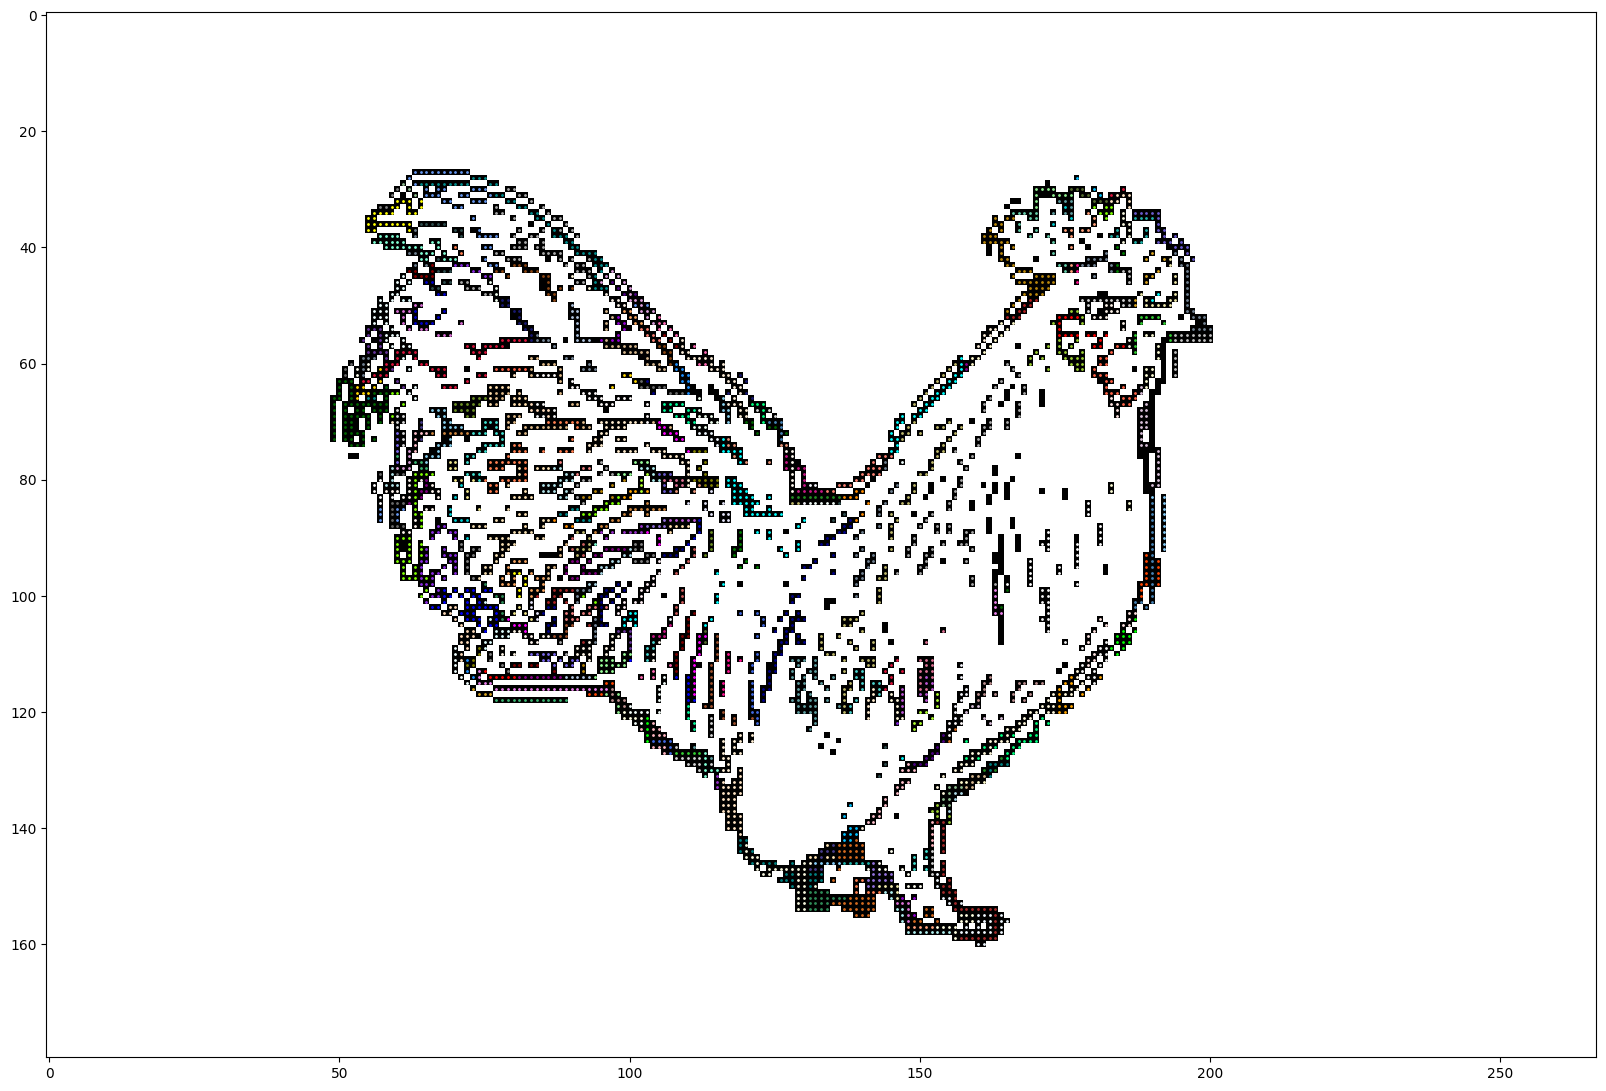

In [33]:
plt.figure(figsize=(20, 20))
plt.imshow(Image.fromarray(curve_img))

colors = list(matplotlib.colors.cnames.keys())

cnt = 0
for line in sorted(lines, key=lambda x: len(x)):
    if point_to_node_dict[line[0]] not in target_nodes or point_to_node_dict[line[-1]] not in target_nodes:
        continue

    x = [p[1] for p in line]
    y = [p[0] for p in line]
    plt.scatter(x, y, s=1, c=colors[cnt])
    
    cnt += 1
    if cnt >= len(colors):
        cnt = 0

In [34]:
G = nx.MultiGraph()
G.add_nodes_from([x for x in range(max(point_to_node_dict.values()) + 1) if x in target_nodes])

for line in lines:
    start_node = point_to_node_dict[line[0]]
    end_node = point_to_node_dict[line[-1]]
    
    if start_node not in target_nodes or end_node not in target_nodes:
        continue

    G.add_edge(start_node, end_node, weight=len(line))

In [35]:
!pip install ortoolpy


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 0.0/17.7 MB ? eta -:--:--
      --------------------------------------- 0.3/17.7 MB 9.6 MB/s eta 0:00:02
     - -------------------------------------- 0.6/17.7 MB 6.4 MB/s eta 0:00:03
     -- ------------------------------------- 1.1/17.7 MB 10.0 MB/s eta 0:00:02
     --- ------------------------------------ 1.4/17.7 MB 7.8 MB/s eta 0:00:03
     ---- ----------------------------------- 2.0/17.7 MB 8.6 MB/s eta 0:00:02
     ----- ---------------------------------- 2.2/17.7 MB 8.8 MB/s eta 0:00:02
     ------ --------------------------------- 2.9/17.7 MB 9.2 MB/s eta 0:00:02
     ------- -------------------------------- 3.2/17.7 MB 8.9 MB/s eta 0:00:02
     -------- ------------------------------- 3.7/17.7 MB 9.0 MB/s eta 0:00:02
     --------- ------------------------------ 4.0/17.7 MB 8.9 MB/s eta 0:00:02
     ---------- ----------------------------- 4.4/17.7 MB 8.8 MB/s eta 0:00:02
     ---------- ----------------------------- 4.8/17.7 MB

In [36]:
from ortoolpy import chinese_postman
_, path = chinese_postman(G)

In [37]:
node_pair_to_lines_dict = defaultdict(list)
for line in lines:
    start_node = point_to_node_dict[line[0]]
    end_node = point_to_node_dict[line[-1]]
    if start_node > end_node:
        start_node, end_node = end_node, start_node
        line = line[::-1]
        
    node_pair_to_lines_dict[(start_node, end_node)].append(line)

node_pair_to_shortest_line_dict = {}
for k, v in node_pair_to_lines_dict.items():
    node_pair_to_shortest_line_dict[k] = min(v, key=len)

In [38]:
single_stroke_path = []
for start_node, end_node in path:
    reverse = 1
    if start_node > end_node:
        start_node, end_node = end_node, start_node
        reverse = -1
    
    if (start_node, end_node) in node_pair_to_lines_dict:
        single_stroke_path.append((start_node, end_node)[::reverse])
    else:
        nodes = nx.dijkstra_path(G, *(start_node, end_node)[::reverse])
        for start_node, end_node in zip(nodes, nodes[1:]):
            single_stroke_path.append((start_node, end_node))

In [39]:
single_stroke_line = []
for start_node, end_node in single_stroke_path:
    reverse = 1
    if start_node > end_node:
        start_node, end_node = end_node, start_node
        reverse = -1
    
    if (start_node, end_node) in node_pair_to_lines_dict and len(node_pair_to_lines_dict[(start_node, end_node)]) > 0:
        line = node_pair_to_lines_dict[(start_node, end_node)].pop()[::reverse]
        single_stroke_line.extend(line)
    elif (start_node, end_node) in node_pair_to_shortest_line_dict:
        line = node_pair_to_shortest_line_dict[(start_node, end_node)][::reverse]
        single_stroke_line.extend(line)
    else:
        raise ValueError()

In [40]:
remove_duplicate_single_stroke_line = []
prev_point = None
for point in single_stroke_line:
    if prev_point is None:
        remove_duplicate_single_stroke_line.append(point)
        prev_point = point
    elif point != prev_point:
        remove_duplicate_single_stroke_line.append(point)
        prev_point = point
    else:
        continue

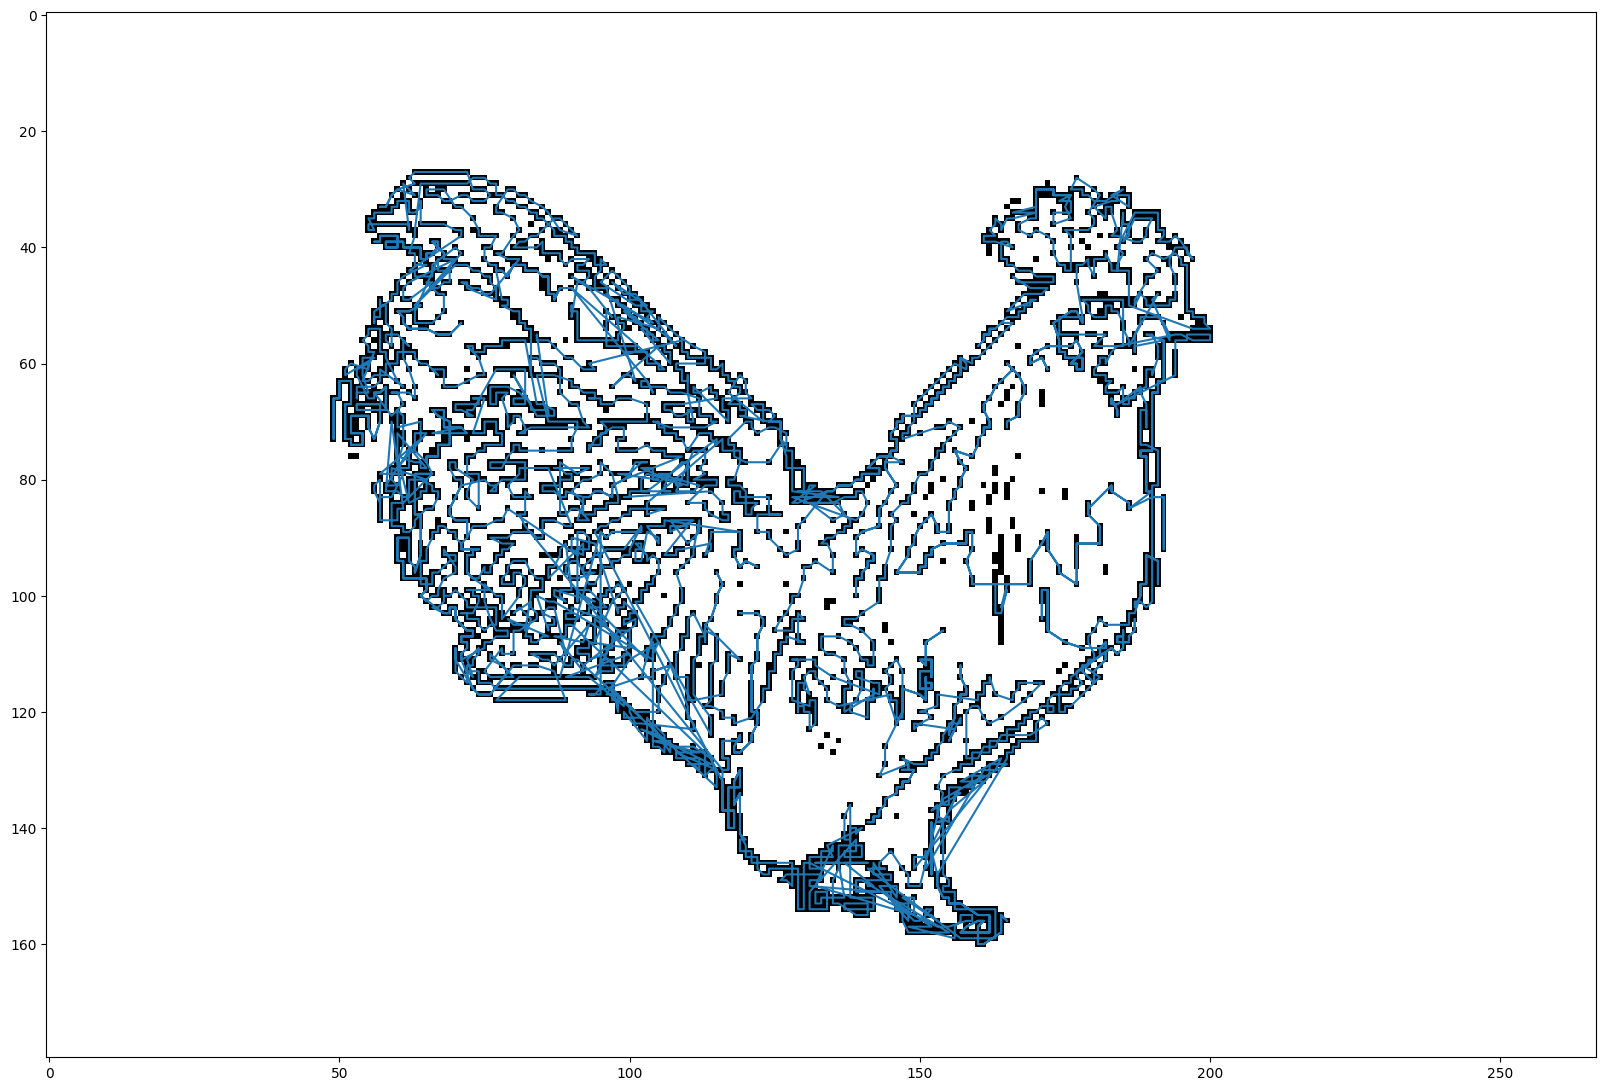

In [41]:
plt.figure(figsize=(20, 20))
plt.imshow(Image.fromarray(curve_img))

x = [p[1] for p in remove_duplicate_single_stroke_line]
y = [p[0] for p in remove_duplicate_single_stroke_line]
plt.plot(x, y)

In [42]:
from scipy import interpolate

l = len(x)
t = np.linspace(0, 1, l-2, endpoint=True)
t = np.append([0, 0, 0], t)
t = np.append(t, [1, 1, 1])
tck=[t, [x, y], 3]
u = np.linspace(0, 1, num=30000, endpoint=True) 
a, b = interpolate.splev(u, tck)

In [43]:
remove_duplicate_single_stroke_line = list(zip(b, a))

In [44]:
path_length = 0
for p1, p2 in zip(remove_duplicate_single_stroke_line, remove_duplicate_single_stroke_line[1:]):
    path_length += np.linalg.norm(np.array(p1) - np.array(p2))

In [45]:
reparameterized_single_stroke_line = [
    (-(x - int(curve_img.shape[0] / 2)) / path_length, (y - int(curve_img.shape[1] / 2)) / path_length)
    for x, y in remove_duplicate_single_stroke_line
]

In [46]:
from scipy.fftpack import fft, ifft

In [47]:
x_fft = fft([point[1] for point in reparameterized_single_stroke_line])
y_fft = fft([point[0] for point in reparameterized_single_stroke_line])

def anime_character_equation(t, n):
    k = np.arange(n)
    c = np.ones(n)
    c[0] = 0.5
    x = np.sum(c * x_fft.real[:n] * np.cos(k * t) + c * x_fft.imag[:n] * np.sin(k * t))
    y = np.sum(c * y_fft.real[:n] * np.cos(k * t) + c * y_fft.imag[:n] * np.sin(k * t))
    return x, y

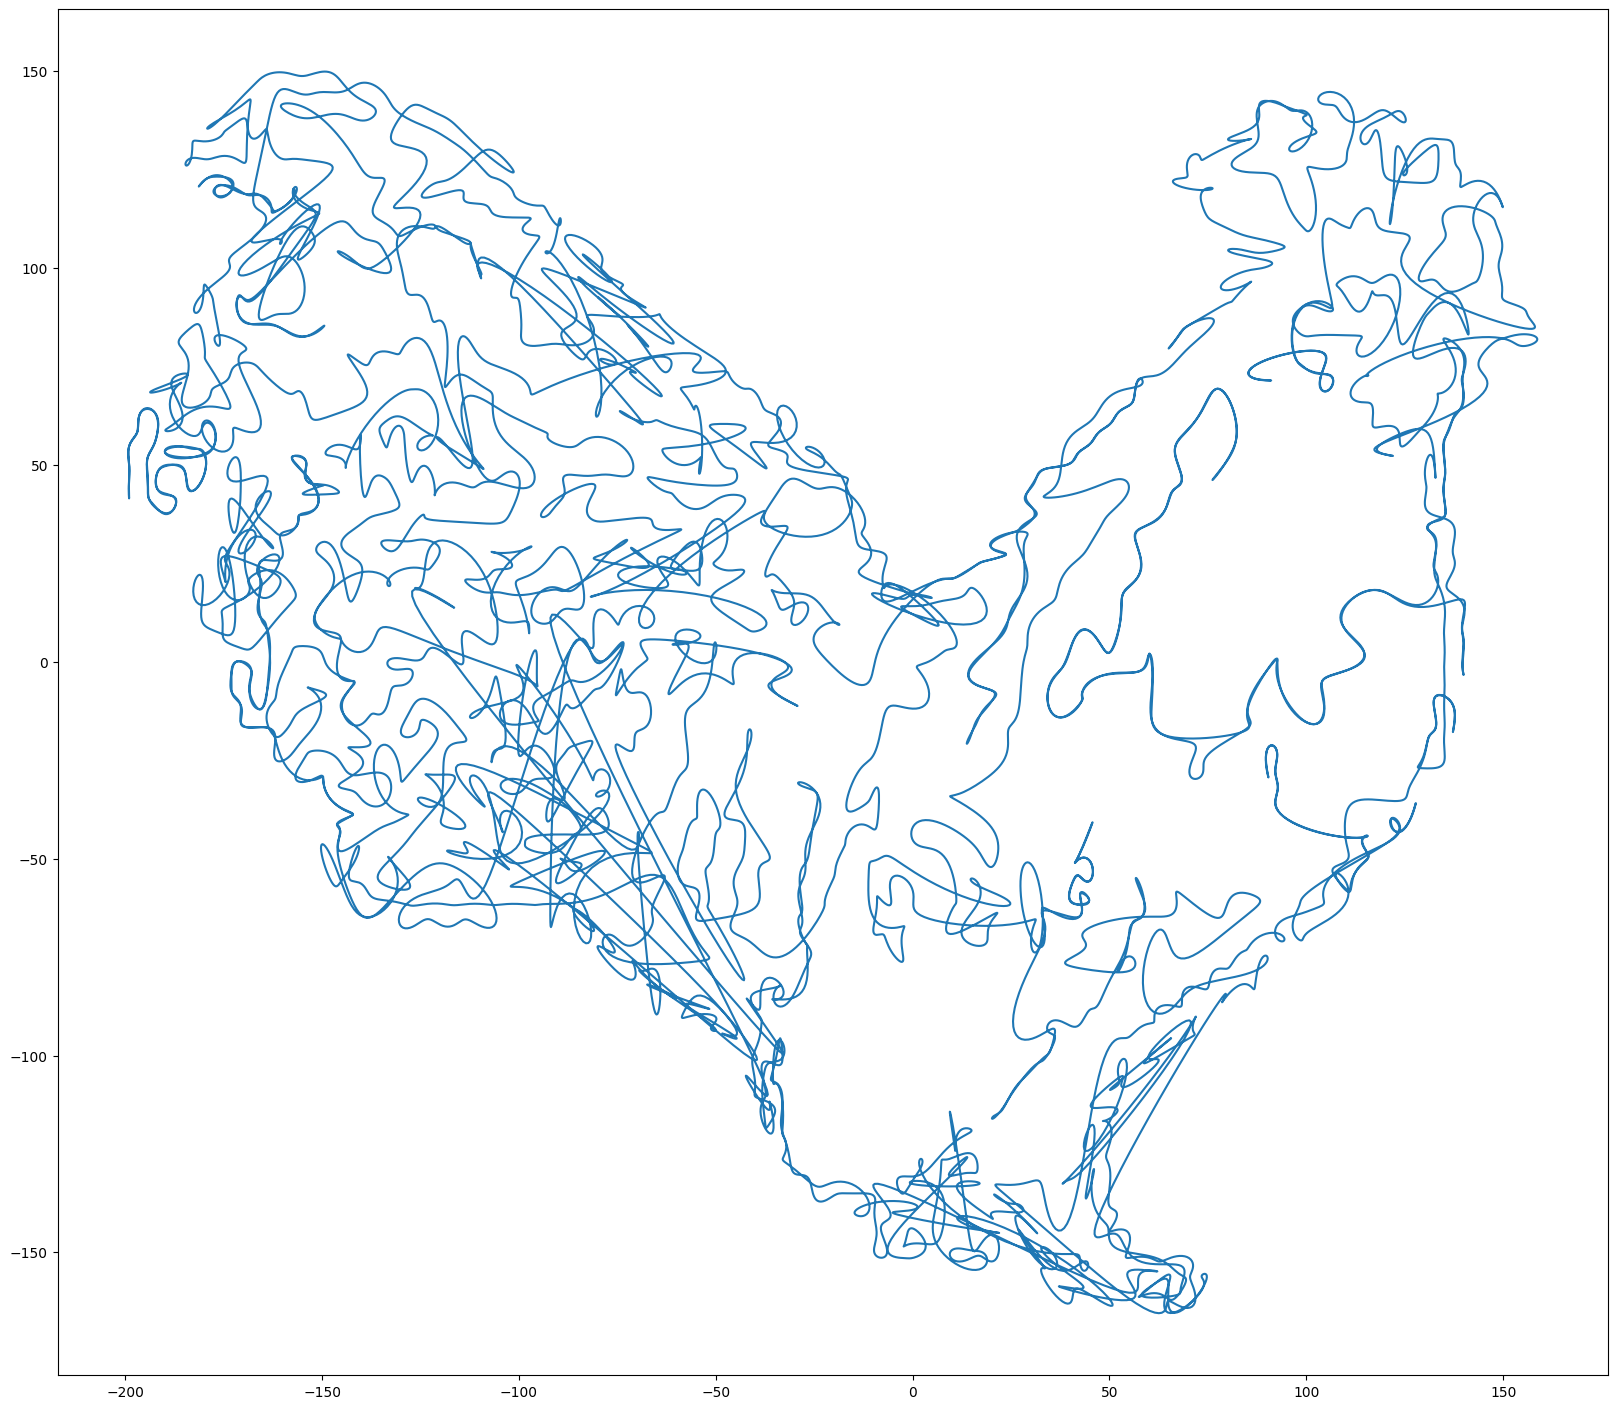

In [48]:
plt.figure(figsize=(20, 20))
plt.axes().set_aspect('equal')
ts = np.linspace(-np.pi, np.pi, 20000)
ds = [anime_character_equation(t, 1000) for t in ts]
x = [d[0] for d in ds]
y = [d[1] for d in ds]
plt.plot(x, y)

In [49]:
xs, ys = [], []
for n in tqdm.tqdm(list(range(5000, 0, -10))):
    ts = np.linspace(-np.pi, np.pi, 20000)
    ds = [anime_character_equation(t, n) for t in ts]
    x = [d[0] for d in ds]
    y = [d[1] for d in ds]
    xs.append(x)
    ys.append(y)

 11%|█         | 53/500 [03:56<31:01,  4.16s/it]

In [ ]:
import pickle
import os
pickle.dump([xs, ys], open(f"{os.path.dirname('__file__')}/data.pickle", "wb"))

In [51]:
import pickle
xs, ys = pickle.load(open(f"{os.path.dirname('__file__')}/data.pickle", "rb"))

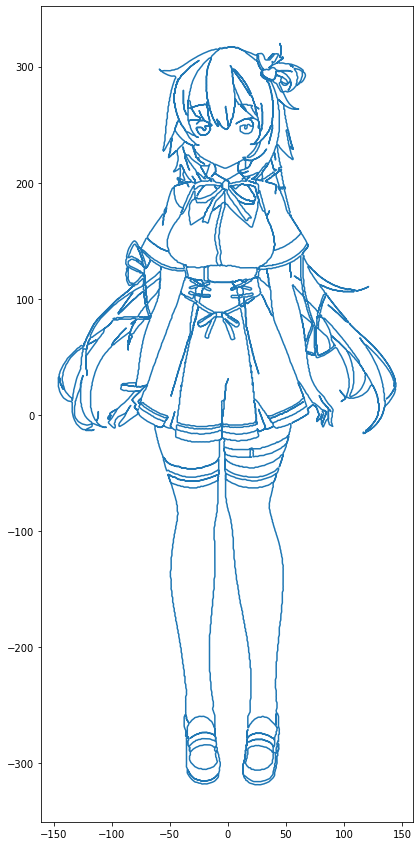

In [52]:
plt.figure(figsize=(15, 15))
plt.axes().set_aspect('equal')
plt.plot(xs[0], ys[0])

In [53]:
xs = xs[::-1]
ys = ys[::-1]

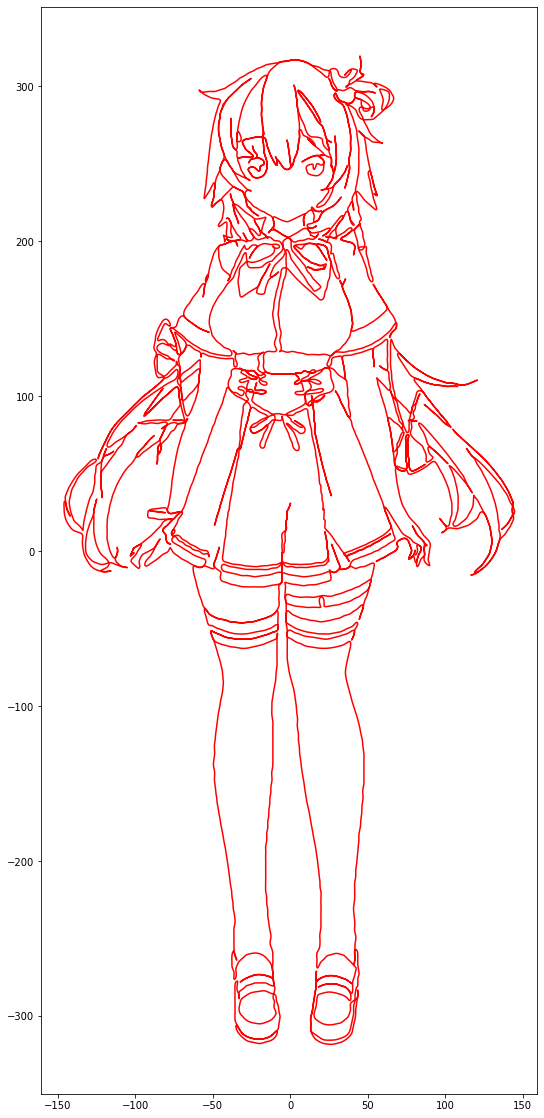

In [57]:
plt.figure(figsize=(20, 20))
plt.axes().set_aspect('equal')
plt.plot(xs[200], ys[200], "r")

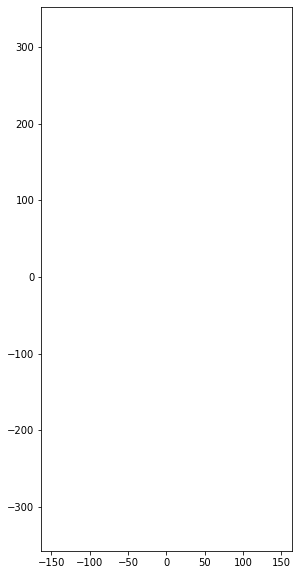

In [58]:
fig = plt.figure(figsize=(10, 10))
plt.axes().set_aspect('equal')

ims = []
for x, y in zip(xs[:200], ys[:200]):
    line, = plt.plot(x, y, "r")
    ims.append([line])

ani = animation.ArtistAnimation(fig, ims, interval=50)
ani.save('anim.gif', writer='pillow')